In [1]:
import cv2
import numpy as np
from numpy import array, zeros, abs, max, sqrt, arctan2, arctan, pi, real
from numpy.fft import fft2, ifft2
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow, show, subplot, figure, gray, title, axis

In [2]:
#FUNCTION LIST##########################################################################################
########################################################################################################


#This function performs a 5x5 gaussian filter on the input image (returns blurred image)  
def GaussianBlurFunction(image):
    
    #Gaussian Kernal by Oleg Shipitko
    gaussianKernal = array([[1, 4,  7,  4,  1],
                           [4, 16,  26, 16,  4],
                           [7, 26, 41, 26, 7],
                           [4, 16,  26, 16,  4],
                           [1, 4,  7,  4,  1]]) / 273;  
    
    
    #Creat kernal the same dimentions as the imput image
    kernel = zeros(image.shape)
    #Using the X & Y dimentions of the 5x5 gaussian kernal apply as mask
    kernel[:gaussianKernal.shape[0], :gaussianKernal.shape[1]] = gaussianKernal
    
    #Perform 2-dimensional discrete Fourier Transform on the subject image
    FrontTransImage = fft2(image)
    #Perform 2-dimensional discrete Fourier Transform on mask
    FrontTransKernel = fft2(kernel)
    #Using DTFT's convoltuional property multiple the two DTFT results together to apply the gaussian kernal
    #Then perform an inverse transform to convert the result back from the Fourier plane 
    gaussianResult = ifft2(FrontTransImage * FrontTransKernel)
    
    #Return the blurred image (removing sign)
    return abs(gaussianResult).astype(int)

#####################################################################################################
#####################################################################################################

#This function runs a sobel kernal for both x & y dimensions then calculates both the gradient intensity and edge direction
def gradientCalculationFunction(image):
    
    #Gx sobel kernal (sourced: Ashish, 2018)
    GxKernal = array([[-1, 0, 1],
                 [-2, 0, 2],
                 [-1, 0, 1]])
    #Gy sobel kernal (sourced: Ashish, 2018)
    GyKernal = array([[-1, -2, -1],
                 [ 0,  0,  0],
                 [ 1,  2,  1]])
    
    #Create matrix with identical dimensions as the input image 
    SobelXMatrix = zeros(image.shape)
    #Fit the Gx sobel kernal to the top left of the matrix as a mask
    SobelXMatrix[:GxKernal.shape[0], :GxKernal.shape[1]] = GxKernal
    #Perform DTFT on the matrix 
    SobelXMatrix = fft2(SobelXMatrix)
    
    #Repeat the previous 3 steps above but for the Gy sobel kernal
    SobelYMatrix = zeros(image.shape)
    SobelYMatrix[:GyKernal.shape[0], :GyKernal.shape[1]] = GyKernal
    SobelYMatrix = fft2(SobelYMatrix)
    
    #Perform DTFT on the input image 
    InputImageMatrix = fft2(image)
    #Using DTFT's convoltuional property multiple both the Gx & Gy DTFT result with the input image DTFT result respectivley
    #Then perfrom the inverse transform the convert the matrix values back from the Fourier plane
    Gx = real(ifft2(SobelXMatrix * InputImageMatrix)).astype(float)
    Gy = real(ifft2(SobelYMatrix * InputImageMatrix)).astype(float)
    
    #Calculate gradient intensity
    G = sqrt(Gx**2 + Gy**2)
    #Calculate Edge direction
    Theta = arctan2(Gy, Gx) * 180 / pi
    #Return both
    return G, Theta

#####################################################################################################
#####################################################################################################

#This function performs non-maximum supression on the input image, reducing edge thickness
def NonMaximumSupressionFunction(gIntensityMat, EdgeDirMat):
     
    #Create zero matrix with identicle dimensions to the gradient intensity matrix
    NMSResultMat = zeros(gIntensityMat.shape)
  
    #Iterate through every cell (pixel) of the result matrix 
    for i in range(NMSResultMat.shape[0]):
        for j in range(NMSResultMat.shape[1]):
            
            #Remove negative edge values and replace with default 360
            if EdgeDirMat[i][j] < 0:
                EdgeDirMat[i][j] += 360
            
            #If the current pixel is within the bounds of the original image
            if ((j+1) < NMSResultMat.shape[1]) and ((j-1) >= 0) and ((i+1) < NMSResultMat.shape[0]) and ((i-1) >= 0):
                
                #If the current pixel possesses an angle of 0 degree threshold
                if (EdgeDirMat[i][j] >= 337.5 or EdgeDirMat[i][j] < 22.5) or (EdgeDirMat[i][j] >= 157.5 and EdgeDirMat[i][j] < 202.5):
                    #Check if the neighbouring horizontal pixels possess a greater intensity value than the current
                    if gIntensityMat[i][j] >= gIntensityMat[i][j + 1] and gIntensityMat[i][j] >= gIntensityMat[i][j - 1]:
                        #Set the corresponding pixel to the this intensity
                        NMSResultMat[i][j] = gIntensityMat[i][j]
                        
                #If the current pixel possesses an angle of 45 degree threshold
                if (EdgeDirMat[i][j] >= 22.5 and EdgeDirMat[i][j] < 67.5) or (EdgeDirMat[i][j] >= 202.5 and EdgeDirMat[i][j] < 247.5):
                    #Check if the neighbouring right-diagonal pixels possess a greater intensity value than the current
                    if gIntensityMat[i][j] >= gIntensityMat[i - 1][j + 1] and gIntensityMat[i][j] >= gIntensityMat[i + 1][j - 1]:
                        #Set the corresponding pixel to the this intensity
                        NMSResultMat[i][j] = gIntensityMat[i][j]
                        
                #If the current pixel possesses an angle of 90 degree threshold
                if (EdgeDirMat[i][j] >= 67.5 and EdgeDirMat[i][j] < 112.5) or (EdgeDirMat[i][j] >= 247.5 and EdgeDirMat[i][j] < 292.5):
                    #Check if the neighbouring verticle pixels possess a greater intensity value than the current
                    if gIntensityMat[i][j] >= gIntensityMat[i - 1][j] and gIntensityMat[i][j] >= gIntensityMat[i + 1][j]:
                        #Set the corresponding pixel to the this intensity
                        NMSResultMat[i][j] = gIntensityMat[i][j]
                        
                #If the current pixel possesses an angle of 135 degree threshold
                if (EdgeDirMat[i][j] >= 112.5 and EdgeDirMat[i][j] < 157.5) or (EdgeDirMat[i][j] >= 292.5 and EdgeDirMat[i][j] < 337.5):
                    #Check if the neighbouring left diagonal pixels possess a greater intensity value than the current
                    if gIntensityMat[i][j] >= gIntensityMat[i - 1][j - 1] and gIntensityMat[i][j] >= gIntensityMat[i + 1][j + 1]:
                        #Set the corresponding pixel to the this intensity
                        NMSResultMat[i][j] = gIntensityMat[i][j]
                        
    #Return non-maximum supression result
    return NMSResultMat

#####################################################################################################
#####################################################################################################

#Using two threshold values to identify high, low and non-relevant pixels
def DoubleThresholdingFunction(image, lowerThreshFactor, upperThreshFactor):
    
    #Create a zero matrix with identical dimensions as the input image
    thresholdResultMat  = zeros(image.shape)
        
    #Set lower and upper intensity values to set pixels that outside of the calculated threshold
    lowerIntensityValue   = 0.5
    upperIntensityValue = 1.0
    
    #Get the maximum intensity value from the input image
    MaxImageValue = max(image)
    
    #Using the maximum value, set the lower and upper threshold values using experimented values (0.15 & 0.75)
    lowerThreshold = lowerThreshFactor * MaxImageValue
    upperThreshold = upperThreshFactor * MaxImageValue
    
    listOfGreaterPixelValues = []
    
    #Interate over each pixel in the input image
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            
            #Set pixel variable for the current pixel being assessed
            pixel = image[i][j]
            
            #If the current pixel exceeds the upper threshold
            if pixel >= upperThreshold:
                #Assign it the value of the upper intensity value
                thresholdResultMat[i][j] = upperIntensityValue
                #Add it to the list of greater pixel values
                listOfGreaterPixelValues.append((i, j))
            #If the current pixel is below the lower threshold
            elif pixel >= lowerThreshold:
                 #Assign it the value of the lower intensity value
                thresholdResultMat[i][j] = lowerIntensityValue
                
    #Return the resulting threshold matrix, ############ i may be able to remove these
    return thresholdResultMat, listOfGreaterPixelValues, lowerIntensityValue, upperIntensityValue

#####################################################################################################
#####################################################################################################

#Using the pixel classification during doubole thresholding, detect possible edges using proximity
def EdgeTrackingByHysteresisFunction(image, lowerIntensityValue, upperIntensityValue):
    
    #Interate over each pixel in the image
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):

            #If the current pixel is equal to the minimum intensity value
            if (image[i,j] == lowerIntensityValue):
                #Check to see if its surrounding neighbourhood have high intensity values (edge property)                
                try:                    
                    if ((image[i+1, j-1] == upperIntensityValue) 
                        or (image[i+1, j] == upperIntensityValue) 
                        or (image[i+1, j+1] == upperIntensityValue) 
                        or (image[i, j-1] == upperIntensityValue) 
                        or (image[i, j+1] == upperIntensityValue) 
                        or (image[i-1, j-1] == upperIntensityValue) 
                        or (image[i-1, j] == upperIntensityValue) 
                        or (image[i-1, j+1] == upperIntensityValue)):
                        image[i, j] = upperIntensityValue
                    else:
                        #Else we define this as not part of an edge and we remove it
                        image[i, j] = 0
                    #A catch to ignore index error
                except IndexError as e:
                    pass
                
    #return the processed image
    return image

#####################################################################################################
#####################################################################################################

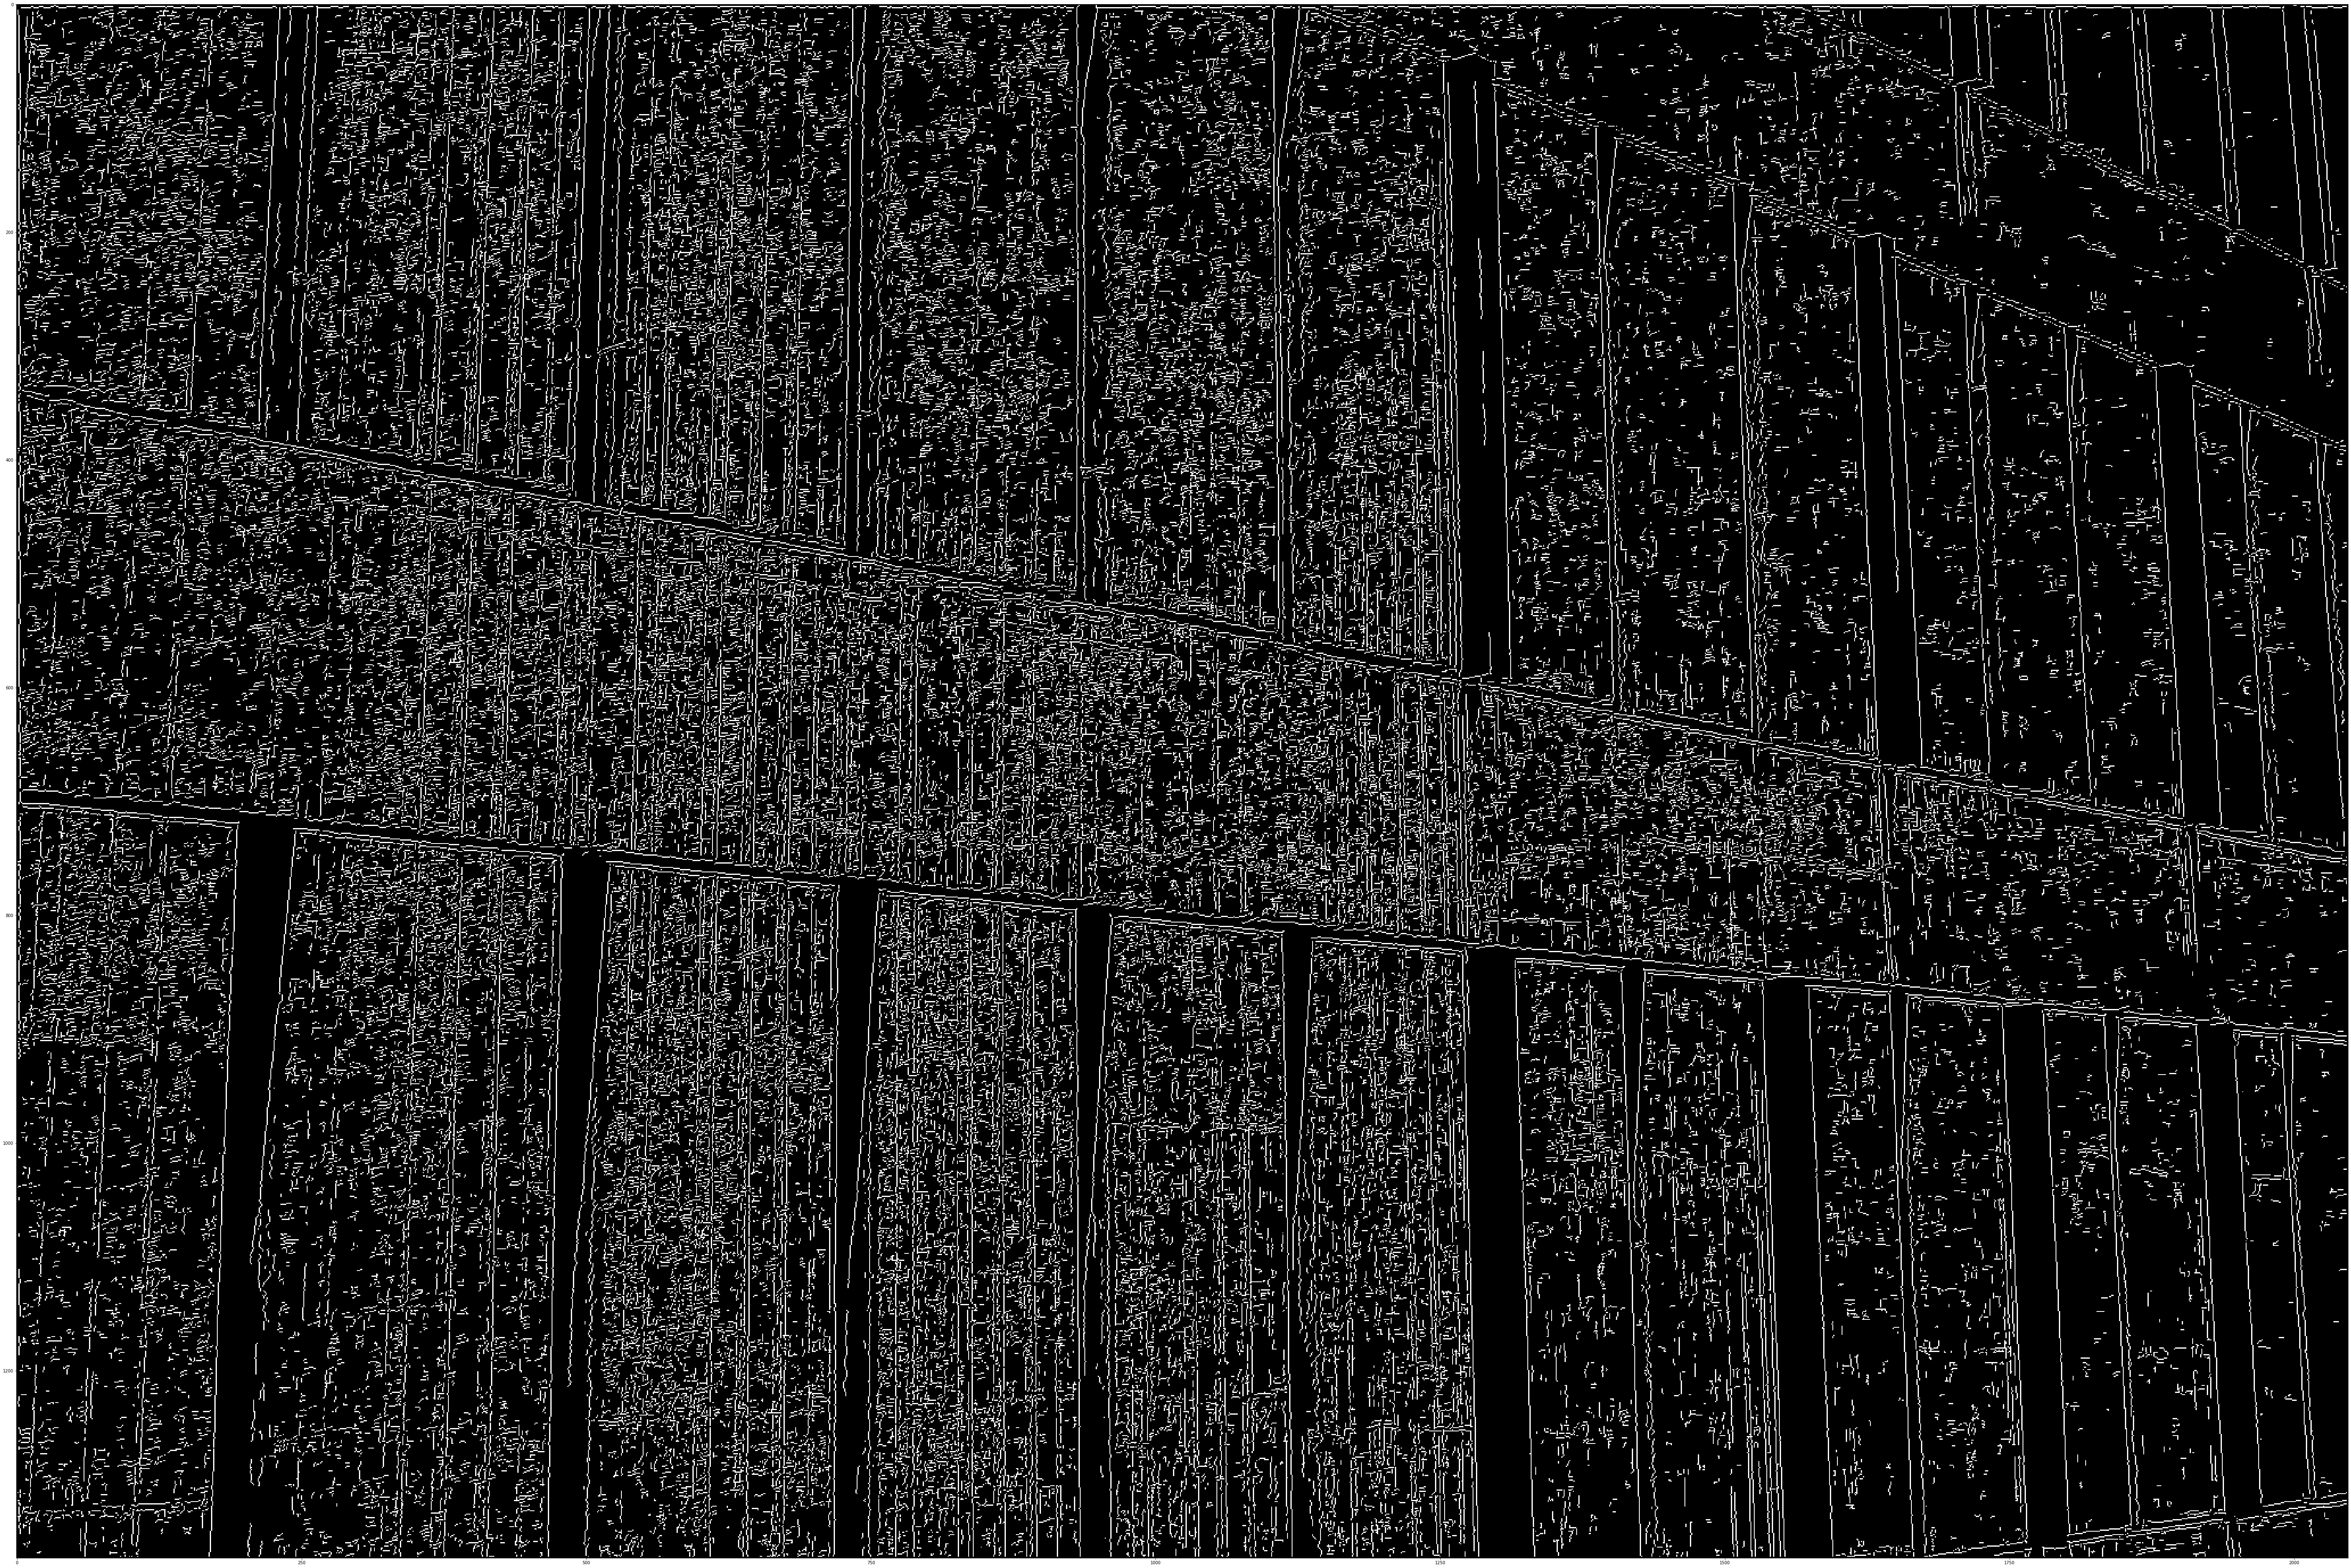

In [3]:
#MAIN CODE WORKFLOW#####################################################################################
########################################################################################################

#Read image
image = cv2.imread('INSERT IMAGE LOCATION HERE',0)
#Noise reduction using gaussian filter
BlurredImage = GaussianBlurFunction(image)
#Gradient calculation by applying sobel filters and finding intensity and angle maps
gradientIntensity, edgeDirection = gradientCalculationFunction(BlurredImage)
#Non-maxiumum supression (reduceing line thickness)
nonMaxSupression = NonMaximumSupressionFunction(gradientIntensity, edgeDirection)
#Double thresholding
thresholdObject = DoubleThresholdingFunction(nonMaxSupression, 0.03, 0.07)
#Edge detection by Hysteresis
cannyImage = EdgeTrackingByHysteresisFunction(thresholdObject[0], thresholdObject[2], thresholdObject[3])

#Show my canny edge detection result (full size)
plt.subplots(figsize=(100,100))
plt.imshow(cannyImage,cmap = 'gray')

TypeError: Image data of dtype object cannot be converted to float

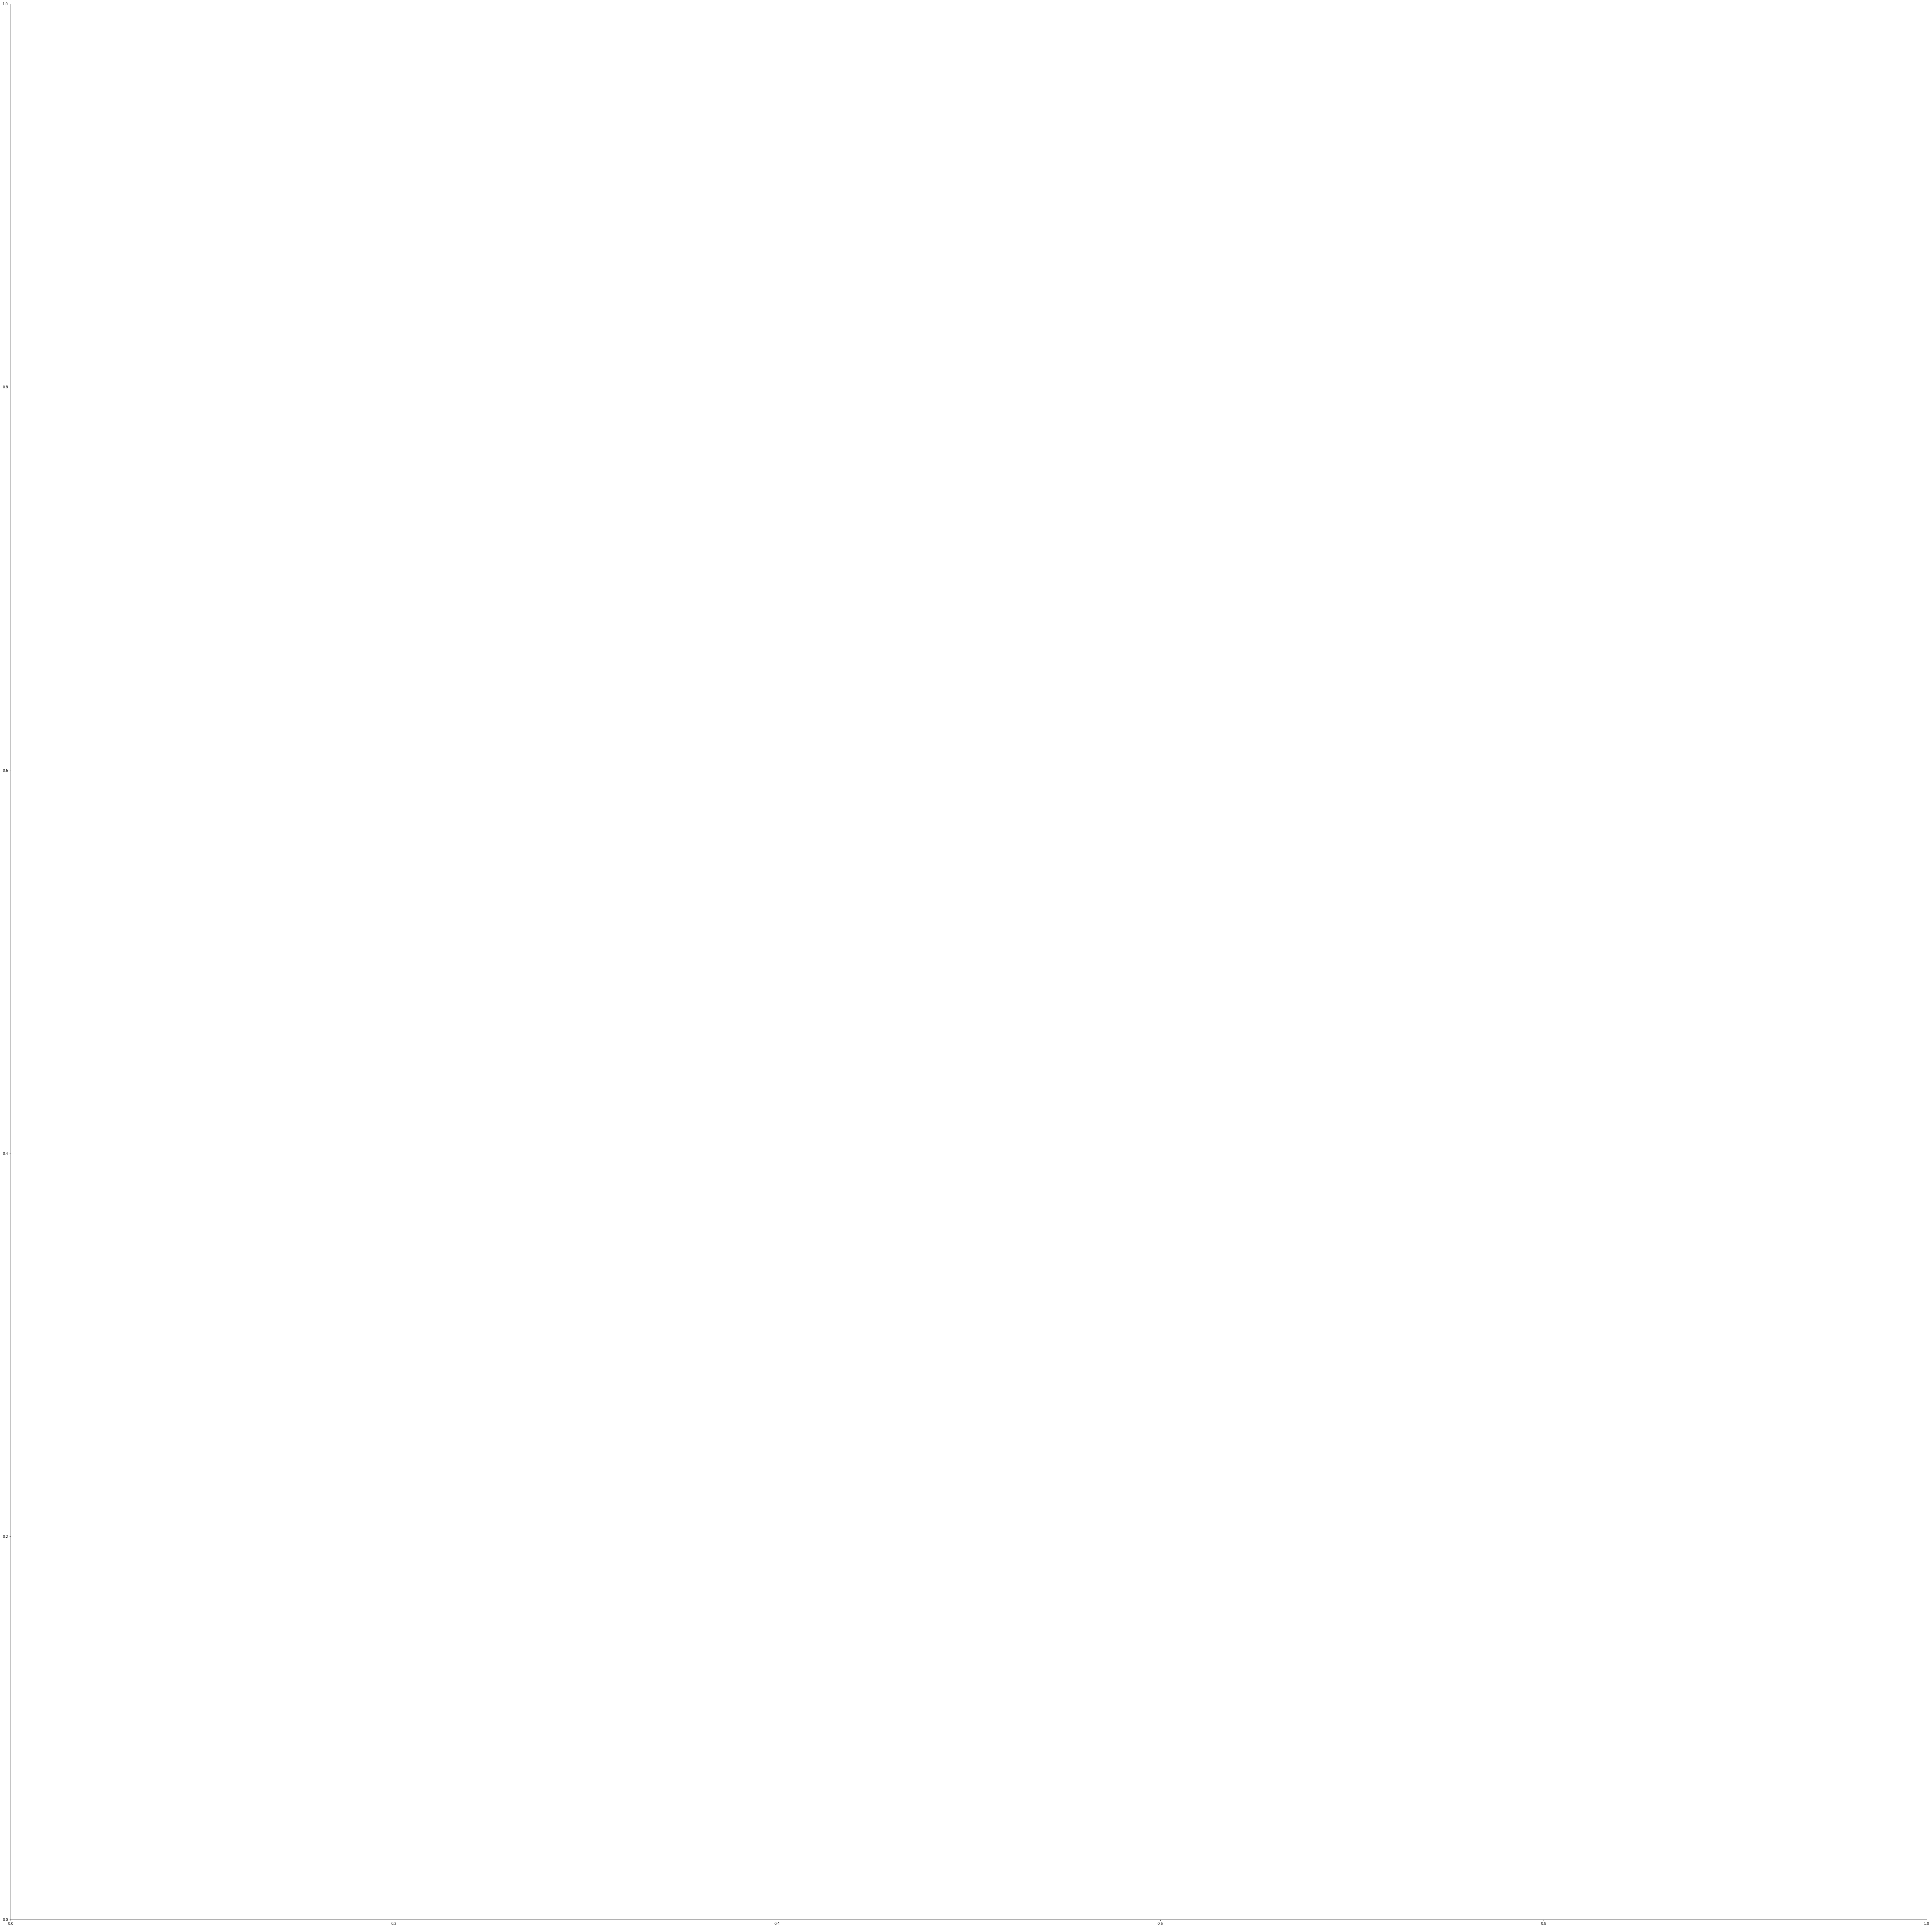

In [4]:
#OPEN CV CANNY EDGE DETECTION COMPARISON################################################################
########################################################################################################

#Run the black box OpenCV Canny edge detection function
originalImage = cv2.imread('INSERT IMAGE LOCATION HERE',0)
cannyResult = cv2.Canny(originalImage,40,90)

#Show my canny edge detection result (full size)
plt.subplots(figsize=(100,100))
plt.imshow(cannyResult,cmap = 'gray')